In [ ]:
# signal detection using gibbs sampling
pi=3.14159265359
import numpy as np
import copy
temperature=1
N=10
p=5
T=2.1*(1e-6)
C=np.array([1+1j,1-1j,-1+1j,-1-1j])# 4qam
def func(k,n,N,T,mu):
  z=1-np.exp(complex(0,-2*pi*((np.float(k-n))/N-mu*T)))
  if(z==complex(0,0)):
    return complex(N,0)
  return (1-np.exp(complex(0,-2*pi*(k-n-mu*N*T))))/z
a=np.array([1.0,0.7,0.5,0.4,0.1])
mu=np.array([0.0,0.4*2.1/T,0.3*2.1/T,0.5*2.1/T,0.9*2.1/T])
tau=np.array([0.0,T,2*T,3*T,4*T])

csi_error=0.01
ahat=np.zeros((1,len(a)),dtype=np.float)
muhat=np.zeros((1,len(mu)),dtype=np.float)
for i in range(len(ahat)):
  ahat[i]=a
  muhat[i]=mu
error_a=csi_error*np.random.randn(len(ahat),len(a))
error_mu=csi_error*np.random.randn(len(muhat),len(mu))
ahat=ahat+error_a
muhat=muhat+error_mu

H=np.zeros((N,N),dtype=complex)
for i in range(N):
  for j in range(N):
    tmp1=complex(0,0)
    for t in range(p):
      tmp1=tmp1+a[t]*np.exp(complex(0,-2*pi*mu[t]*tau[t]))*func(i,j,N,T,mu[t])
    H[i,j]=tmp1/N
Hinv=np.linalg.inv(H)

def normc(v):
  l=len(v)
  ret=0.0
  for i in range(l):
    ret+=(np.absolute(v[i]))**2
  return ret**0.5
def find(v,i,y,H,C,sigma):
  tmp=v[i]
  minm=np.float(1e15)
  x=complex(0,0)
  z=0.0
  for j in range(4):
    v[i]=C[j]
    z=normc(y-H.dot(v))
    if(z<=minm):
      minm=z
      x=C[j]
      ret=z
  v[i]=tmp
  if(tmp==x):
    return x,0.0
  ret=np.exp(-(ret**2)/((sigma**2)*(temperature**2)))
  return x,ret

def ispos(x,C):
  l=len(x)
  dic={1+1j:0,1-1j:1,-1+1j:2,-1-1j:3}
  
  for i in range(l):
    if dic.get(x[i])==None:
      return False
  return True

def func2(y,Hinv,H,C,sigma,ite,maxsteps):
  xhat=Hinv.dot(y)
  l=len(y)
  z=np.zeros((l,),dtype=complex)
  prob=np.zeros((l,),dtype=float)
  minm=1e15
  reqx=np.zeros((l,),dtype=complex)
  for k in range(l):
    minm=1e15
    for j in range(len(C)):
      tmp2=np.absolute(C[j]-xhat[k])
      if(tmp2<minm):
        minm=tmp2
        reqx[k]=C[j]
  
  mincost=normc(y-H.dot(reqx))
  for i in range(ite):
    xhat=Hinv.dot(y)
    #mincost=1e15
    
    for j in range(maxsteps):
      tmp=0.0
      for k in range(l):
        z[k],prob[k]=find(xhat,k,y,H,C,sigma)
        tmp+=prob[k]
      if(tmp==0):
        cost=normc(y-H.dot(xhat))
        if(cost<=mincost  ):
          mincost=cost
          reqx=copy.deepcopy(xhat)
        #print("iteration",i,"step",j,"x",xhat,"cost",cost)
        break
      prob=prob/tmp
      auxflag=0
      for i2 in range(len(prob)):
        if(np.isnan(prob[i2])):
          auxflag=1
          break
      if(auxflag==0):
        c=np.random.choice(l,p=prob)
      else:
        c=np.random.choice(l)
      xhat[c]=z[c]
      cost=normc(y-H.dot(xhat))
      if(cost<=mincost and ispos(xhat,C)):
        mincost=cost
        reqx=copy.deepcopy(xhat)
     # print("iteration",i,"step",j,"x",xhat,"cost",cost)
  return reqx



def func3(y,Hinv,H,C,sigma,ite):
  xhat=Hinv.dot(y)
  l=len(y)
  reqx=np.zeros((l,),dtype=complex)
  for i in range(l):
    minm=1e15
    for j in range(len(C)):
      tmp2=np.absolute(xhat[i]-C[j])
      if(tmp2<minm):
        minm=tmp2
        reqx[i]=C[j]
  for i in range(ite):
    for j in range(l):
      tmp3=0.0
      prob=np.zeros((len(C),),dtype=float)
      #tmp4=reqx[j]
      for k in range(len(C)):
        reqx[j]=C[k]
        prob[k]=np.exp(-(normc(y-H.dot(reqx))**2)/(sigma**2))
        tmp3+=prob[k]
      prob=prob/tmp3
      auxflag=0
      for i2 in range(len(prob)):
        if(np.isnan(prob[i2])):
          auxflag=1
          break
      if(auxflag==0):
        ind=np.random.choice(len(C),p=prob)
      else:
        ind=np.random.choice(len(C))
      reqx[j]=C[ind]
  return reqx

def func3_gibbs(y,Hinv,H,C,sigma,ite):
  xhat=Hinv.dot(y)
  l=len(y)
  
  retx=np.zeros((l,),dtype=complex)
  for i in range(l):
    minm=1e15
    for j in range(len(C)):
      tmp2=np.absolute(xhat[i]-C[j])
      if(tmp2<minm):
        minm=tmp2
        retx[i]=C[j]
  
  reqx=xhat
  max2=normc(y-H.dot(retx))**2
  
  for i in range(ite):
    
    for j in range(l):
      tmp3=0.0
      prob=np.zeros((len(C),),dtype=float)
      max_=np.inf
      maxk=0
      #tmp4=reqx[j]
      for k in range(len(C)):
        reqx[j]=C[k]
        tmp4=(normc(y-H.dot(reqx))**2)
        prob[k]=np.exp(-tmp4/((sigma**2)*(temperature**2)))
        tmp3+=prob[k]
        if(tmp4<max_):
          max_=tmp4
          maxk=k
      prob=prob/tmp3
      auxflag=0
      for i2 in range(len(prob)):
        if(np.isnan(prob[i2])):
          auxflag=1
          break
      if(auxflag==0):
        
      
        ind=np.random.choice(len(C),p=prob)
        reqx[j]=C[ind]
      else:
        ind=maxk
        reqx[j]=ind
      if((normc(y-H.dot(reqx))**2)<max2 and i>0):
        max2=normc(y-H.dot(reqx))**2
        for i3 in range(l):
          retx[i3]=reqx[i3]
  return retx

def func2_gibbs(y,Hinv,H,C,sigma,ite,maxsteps):
  xhat=Hinv.dot(y)
  retx=np.zeros((len(y),),dtype=complex)
  reqx=np.zeros((len(y),),dtype=complex)
  max1=np.inf
  for i in range(ite):
    reqx=func3_gibbs(y,Hinv,H,C,sigma,maxsteps)  
    if((normc(y-H.dot(reqx))**2)<max1):
      max1=normc(y-H.dot(reqx))**2
      for i3 in range(len(y)):
        retx[i3]=reqx[i3]
    
  return retx



In [ ]:
# creating data matrix and calculating signal power
data=np.zeros((4**N,N),dtype=complex)
for i in range(4**N):
  j=0
  t=i
  while(j<N):
    
    data[i,j]=C[t%4]
    j+=1
    t=t//4
print(data[0:8,:])


[[ 1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j
   1.+1.j]
 [ 1.-1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j
   1.+1.j]
 [-1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j
   1.+1.j]
 [-1.-1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j
   1.+1.j]
 [ 1.+1.j  1.-1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j
   1.+1.j]
 [ 1.-1.j  1.-1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j
   1.+1.j]
 [-1.+1.j  1.-1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j
   1.+1.j]
 [-1.-1.j  1.-1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j  1.+1.j
   1.+1.j]]


In [ ]:
# snr

A=H.dot(H.conj().T)
tmp=0.0

for i in range(N):
  #print(A[i,i])
  tmp+=A[i,i]
  
signal=2*tmp
print(signal)
# snr db =0,2,4,6,8,10
snr=np.array([0,1,2,3,4,5,7,10,15,20,25,30])
sigma=np.zeros((len(snr),),dtype=float)
for i in range(len(snr)):
  sigma[i]=signal/((10**(snr[i]/10))*N)
  sigma[i]=sigma[i]**0.5
print(sigma)
tmp1=0.0
for i in range(N):
  tmp1+=np.abs(H[0,i])**2
print(tmp1*2*N)

(48.35705507133285+0j)
[2.19902376 1.95988199 1.74674666 1.5567896  1.38749019 1.23660194
 0.98226783 0.69539237 0.39104787 0.21990238 0.12366019 0.06953924]
48.357055071340284


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [ ]:
import copy
for iterator in range(len(ahat)):
  H2=np.zeros((N,N),dtype=complex)
  for i in range(N):
    for j in range(N):
      tmp1=complex(0,0)
      for t in range(p):
        tmp1=tmp1+ahat[iterator,t]*np.exp(complex(0,-2*pi*muhat[iterator,t]*tau[t]))*func(i,j,N,T,muhat[iterator,t])
      H2[i,j]=tmp1/N
  H2inv=np.linalg.inv(H2)

  n=1000
  xhat=np.zeros((n,N),dtype=complex)
  ind=np.random.choice(4**N,len(sigma)*n,replace=False)
  ber1=np.zeros((len(sigma),),dtype=float)
  ber2=np.zeros((len(sigma),),dtype=float)
  for i in range(len(sigma)):
    acc=0
    V=(sigma[i]/(2**0.5))*np.random.randn(2*n,N)
    awgn=np.zeros((n,N),dtype=complex)
    X=np.zeros((n,N),dtype=complex)
    for j in range(n):
      for k in range(N):
        awgn[j,k]=complex(V[2*j,k],V[2*j+1,k])
      X[j,:]=data[ind[i*n+j],:]
    y=H.dot(X.T)+awgn.T
    y=y.T
    
    for j in range(n):
      xhat[j,:]=func2(y[j,:],H2inv,H2,C,sigma[i],5,20)
      for k in range(N):
        if(xhat[j,k]==X[j,k]):
        
          acc+=1
    ber1[i]=np.float(acc/(n*N))
    acc=0.0
    """
    for j in range(n):
      xhat[j,:]=func3(y[j,:],H2inv,H2,C,sigma[i],10)
      for k in range(N):
        if(xhat[j,k]==X[j,k]):
        
          acc+=1
    ber2[i]=np.float(acc/(n*N))      
"""
  print("ber1", ber1)
  print("ber2", ber2)

KeyboardInterrupt: ignored

In [ ]:
var=0.01
storage=np.zeros((N,N,20),dtype=np.complex)
import copy
for repeat_ in range(1):
  H2=np.zeros((N,N),dtype=complex)
  for iterator in range(len(ahat)):
    for i in range(N):
      for j in range(N):
        #H2[i,j]=H[i,j]+((var/2)**0.5)*complex(np.random.randn(),np.random.randn())
        H2[i,j]=H[i,j]
        storage[i,j,repeat_]=H2[i,j]
    H2inv=np.linalg.inv(H2)

    n=1000
    xhat=np.zeros((n,N),dtype=complex)
    ind=np.random.choice(4**N,len(sigma)*n,replace=False)
    ber1=np.zeros((len(sigma),),dtype=float)
    ber2=np.zeros((len(sigma),),dtype=float)
    for i in range(len(sigma)):
      acc=0
      V=(sigma[i]/(2**0.5))*np.random.randn(2*n,N)
      awgn=np.zeros((n,N),dtype=complex)
      X=np.zeros((n,N),dtype=complex)
    
      for j in range(n):
        for k in range(N):
          awgn[j,k]=complex(V[2*j,k],V[2*j+1,k])
        X[j,:]=data[ind[i*n+j],:]
      y=H.dot(X.T)+awgn.T
      y=y.T
      
      for j in range(n):
        xhat[j,:]=func2(y[j,:],H2inv,H2,C,sigma[i],5,20)
        for k in range(N):
          if(xhat[j,k]==X[j,k]):
        
            acc+=1
      ber1[i]=np.float(acc/(n*N))
      
      acc=0.0
      for j in range(n):
        xhat[j,:]=func2_gibbs(y[j,:],H2inv,H2,C,sigma[i],1,10)
        for k in range(N):
          if(xhat[j,k]==X[j,k]):
        
            acc+=1
      ber2[i]=np.float(acc/(n*N))   

    print("ber1", ber1)
    print("ber2", ber2)

ber1 [0.6482 0.6799 0.7368 0.762  0.8086 0.8447 0.9219 0.9847 0.9992 1.
 1.     1.    ]
ber2 [0.6391 0.6829 0.7399 0.782  0.8308 0.8818 0.9497 0.9917 0.9997 1.
 1.     1.    ]


In [ ]:
temperature=1
#H2=storage[:,:,17]
H2=H
H2inv=np.linalg.inv(H2)

n=1000
xhat=np.zeros((n,N),dtype=complex)
ind=np.random.choice(4**N,len(sigma)*n,replace=False)
ber1_improv=np.zeros((len(sigma),),dtype=float)
ber2_improv=np.zeros((len(sigma),),dtype=float)
for i in range(len(sigma)):
  acc=0
  V=(sigma[i]/(2**0.5))*np.random.randn(2*n,N)
  awgn=np.zeros((n,N),dtype=complex)
  X=np.zeros((n,N),dtype=complex)
    
  for j in range(n):
    for k in range(N):
      awgn[j,k]=complex(V[2*j,k],V[2*j+1,k])
    X[j,:]=data[ind[i*n+j],:]
  y=H.dot(X.T)+awgn.T
  y=y.T
  
  for j in range(n):
    xhat[j,:]=func2(y[j,:],H2inv,H2,C,sigma[i],1,25)
    for k in range(N):
      if(xhat[j,k]==X[j,k]):
        
        acc+=1
  ber1_improv[i]=np.float(acc/(n*N))
"""      
  acc=0.0
  for j in range(n):
    xhat[j,:]=func2_gibbs(y[j,:],H2inv,H2,C,sigma[i],1,125)
    for k in range(N):
      if(xhat[j,k]==X[j,k]):
        
        acc+=1
  ber2_improv[i]=np.float(acc/(n*N))   
"""
print("ber1", ber1_improv)
print("ber2", ber2_improv)

ber1 [0.6427 0.6852 0.7252 0.7499 0.7936 0.8339 0.9019 0.9705 0.998  1.
 1.     1.    ]
ber2 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


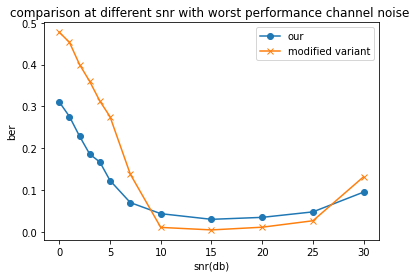

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
array1=np.array([0.6893,0.724,0.7712,0.8139,0.8328,0.8769,0.9296,0.9561,0.9696,0.9649,0.9518,0.9045],dtype=np.float)
array2=np.array([0.5227,0.5468,0.6,0.6403,0.6872,0.7244,0.8618,0.9889,0.9949,0.9884,0.973,0.8678],dtype=np.float)
array3=np.array([0,1,2,3,4,5,7,10,15,20,25,30],dtype=np.float)
array1=1-array1
array2=1-array2

plt.plot(array3,array1,marker='o',label='our')
plt.plot(array3,array2,marker='x',label='modified variant')
plt.title('comparison at different snr with worst performance channel noise ')
plt.xlabel("snr(db)")
plt.ylabel("ber")
plt.legend()
#graph7